# Introduction
We have received finance data about stocks opening, closing prices and other 15 features on which prices are dependent. We'll try to fit various models to this data to check whether returns are positive or not. We have tried 2 versions of Dense Net and 2 versions of LSTMs for predicting whether returns are positive or not.

In [1]:
import pandas as pd
import numpy as np
import math

import sklearn
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, f_regression

from imblearn.over_sampling import SMOTE
import xgboost as xgb

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.utils import plot_model

from PIL import Image
import matplotlib.pyplot as plt

import warnings
import copy
from collections import Counter

warnings.filterwarnings('ignore')

pd.set_option('precision', 3)
np.set_printoptions(precision=3)

%matplotlib inline

Using TensorFlow backend.


# Loading & Cleaning Data
Loading data involved loading data from CSV file wheareas cleaning data refers to handling of NAs. We also have introduced new columns like returns which is percentage change in closing price and label which is 1 if return is positive else 0.

In [2]:
data=pd.read_csv('/kaggle/input/input_data.csv')
data['Time'] = pd.to_datetime(data['Time'].values, format='%m/%d/%Y')
data = data.set_index('Time')
data = data.fillna(0)
data.head()

,Open,High,Low,Close,Volume,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15
Time,,,,,,,,,,,,,,,,,,,,
2008-10-15,14.83,15.29,13.98,13.99,387619900,0.0,-0.641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-10-16,14.25,14.86,13.11,14.56,480128000,0.0,0.177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-10-17,14.21,14.58,13.86,13.91,433964800,0.0,-0.417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-10-20,14.26,14.29,13.38,14.06,383539500,0.0,-0.220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-10-21,13.86,13.99,13.00,13.07,446705000,0.0,-0.798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
def get_vol(prices, span=100, delta=pd.Timedelta(days=4)):
    # 1. compute returns of the form p[t]/p[t-1] - 1
    # 1.1 find the timestamps of p[t-1] values
    df0 = prices.index.searchsorted(prices.index - delta)
    df0 = df0[df0 > 0]
    # 1.2 align timestamps of p[t-1] to timestamps of p[t]
    df0 = pd.Series(prices.index[df0-1], index=prices.index[prices.shape[0]-df0.shape[0] : ])
    # 1.3 get values by timestamps, then compute returns
    df0 = prices.loc[df0.index] / prices.loc[df0.values].values - 1
    # 2. estimate rolling standard deviation
    df0 = df0.ewm(span=span).std()
    return df0

def get_horizons(prices, delta=pd.Timedelta(days=1)):
    t1 = prices.index.searchsorted(prices.index + delta)
    t1 = t1[t1 < prices.shape[0]]
    t1 = prices.index[t1]
    t1 = pd.Series(t1, index=prices.index[:t1.shape[0]])
    return t1

def get_touches(prices, events, factors=[1, 1]):
    '''
    events: pd dataframe with columns
    t1: timestamp of the next horizon
    threshold: unit height of top and bottom barriers
    side: the side of each bet
    factors: multipliers of the threshold to set the height of 
           top/bottom barriers
    '''
    out = events[['t1']].copy(deep=True)
    if factors[0] > 0: thresh_uppr = factors[0] * events['threshold']
    else: thresh_uppr = pd.Series(index=events.index) # no uppr thresh
    if factors[1] > 0: thresh_lwr = -factors[1] * events['threshold']
    else: thresh_lwr = pd.Series(index=events.index)  # no lwr thresh
    for loc, t1 in events['t1'].iteritems():
        df0=prices[loc:t1]                              # path prices
        df0=(df0 / prices[loc] - 1) * events.side[loc]  # path returns
        out.loc[loc, 'stop_loss'] = df0[df0 < thresh_lwr[loc]].index.min()  # earliest stop loss
        out.loc[loc, 'take_profit'] = df0[df0 > thresh_uppr[loc]].index.min() # earliest take profit
    return out

def get_labels(touches):
    out = touches.copy(deep=True)
    # pandas df.min() ignores NaN values
    first_touch = touches[['stop_loss', 'take_profit']].min(axis=1)
    for loc, t in first_touch.iteritems():
        if pd.isnull(t):
            out.loc[loc, 'label'] = 0
        elif t == touches.loc[loc, 'stop_loss']: 
            out.loc[loc, 'label'] = -1
        else:
            out.loc[loc, 'label'] = 1
    return out

In [4]:
data_latest = data.assign(threshold=get_vol(data.Close)).dropna()
data_latest = data_latest.assign(t1=get_horizons(data_latest)).dropna()
events = data_latest[['t1', 'threshold']] 
events = events.assign(side=pd.Series(1., events.index)) # long only
touches = get_touches(data_latest.Close, events, [1,1])
touches = get_labels(touches)
data_latest = data_latest.assign(label=touches.label)

In [5]:
## We have originally 3 labels. 1 - take the long bet, -1 -  take the short bet, 0 - don't take the bet.
## Turning labels into 1 and 0. 1 - trade(positive), 0 - no-trade(negative)
data_latest['label'] = [0 if i==0 else 1for i in data_latest.label] 
data_latest.head()

,Open,High,Low,Close,Volume,feature1,feature2,feature3,feature4,feature5,...,feature9,feature10,feature11,feature12,feature13,feature14,feature15,threshold,t1,label
Time,,,,,,,,,,,,,,,,,,,,,
2008-10-21,13.86,13.99,13.00,13.07,446705000,0.0,-0.798,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076,2008-10-22,0
2008-10-22,13.91,14.46,13.28,13.84,536549400,0.0,-0.059,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.059,2008-10-23,0
2008-10-23,13.83,14.18,13.13,14.03,415305400,0.0,0.190,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.053,2008-10-24,0
2008-10-24,12.89,13.99,12.87,13.77,391752400,0.0,0.786,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046,2008-10-27,0
2008-10-27,13.62,13.95,13.12,13.16,297031300,0.0,-0.554,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043,2008-10-28,1


In [6]:
data_latest.label.unique(), Counter(data_latest.label.values)

(array([0, 1]), Counter({0: 2575, 1: 176}))

## Correlation Between Features and Label/Returns/Close Price/Open Price

Below we have found out correlation between all feaatures and label, returns, close price and open price. We'll use this correlation for plotting purpose below.

In [7]:
corr_between_features_and_label = data_latest[['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10', 'feature11', 'feature12', 'feature13', 'feature14', 'feature15','label']].corr()

In [8]:
corr_between_features_and_label

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,label
feature1,1.000,0.404,0.112,0.786,0.793,-0.170,-0.173,-0.126,0.474,0.531,0.474,0.718,0.355,0.303,0.256,-0.118
feature2,0.404,1.000,0.014,0.281,0.353,-0.012,-0.002,-0.010,0.069,0.102,0.069,0.172,0.088,0.113,0.050,-0.045
feature3,0.112,0.014,1.000,0.305,-0.052,0.142,0.161,0.114,0.377,0.371,0.377,0.052,0.168,0.030,0.163,0.031
feature4,0.786,0.281,0.305,1.000,0.571,-0.228,-0.111,-0.200,0.812,0.849,0.812,0.563,0.419,0.208,0.359,-0.139
feature5,0.793,0.353,-0.052,0.571,1.000,-0.052,-0.260,0.011,0.060,0.133,0.060,0.792,0.182,0.339,0.065,-0.122
feature6,-0.170,-0.012,0.142,-0.228,-0.052,1.000,0.208,0.968,-0.288,-0.291,-0.288,-0.054,-0.161,0.007,-0.169,0.092
feature7,-0.173,-0.002,0.161,-0.111,-0.260,0.208,1.000,-0.035,0.014,-0.002,0.014,-0.301,-0.178,-0.115,-0.142,0.132
feature8,-0.126,-0.010,0.114,-0.200,0.011,0.968,-0.035,1.000,-0.292,-0.291,-0.292,0.020,-0.114,0.035,-0.131,0.061
feature9,0.474,0.069,0.377,0.812,0.060,-0.288,0.014,-0.292,1.000,0.996,1.000,0.213,0.410,0.035,0.413,-0.074
feature10,0.531,0.102,0.371,0.849,0.133,-0.291,-0.002,-0.291,0.996,1.000,0.996,0.268,0.421,0.061,0.414,-0.081


Below bar charts show correlation value (Positive/Negative) between features and label, returns, close price and open price.

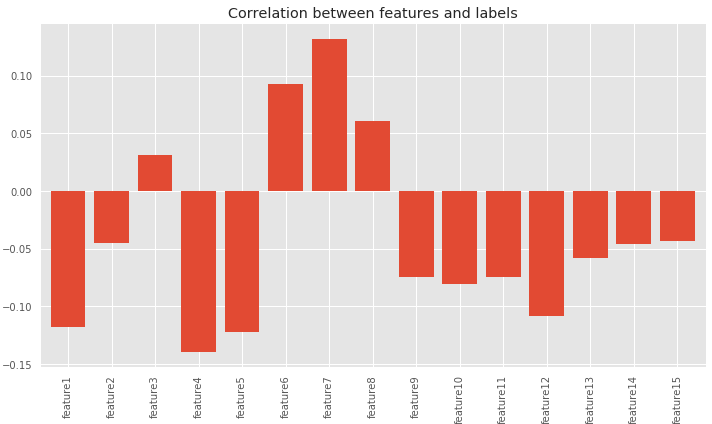

In [9]:
with plt.style.context(('seaborn', 'ggplot')):
    fig = plt.figure(figsize=(10, 6))
    corr_between_features_and_label.loc['label',].drop('label').plot(kind='bar', width=0.8, title='Correlation between features and labels')
    plt.tight_layout()

Below heatmaps shows correlation between various features and label, returns and close price.

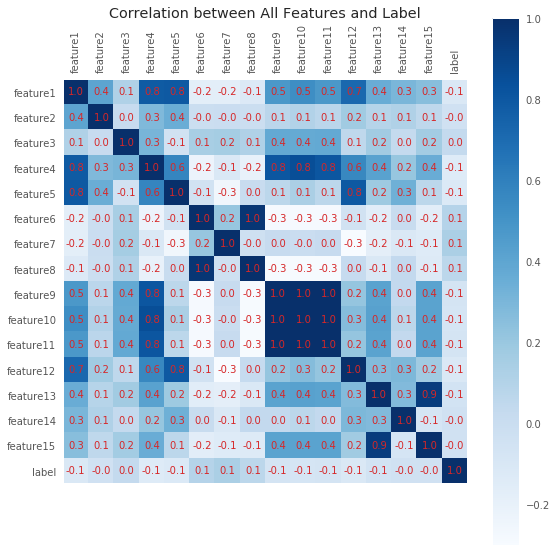

In [10]:
def plot_correlation_matrix(df, titl):
    plt.imshow(df.values, cmap=plt.cm.Blues)
    plt.xticks(range(df.shape[0]), df.columns, rotation='vertical')
    plt.yticks(range(df.shape[0]), df.columns)
    plt.title(titl)
    plt.colorbar()
    plt.grid(None)
    for i in range(0,df.shape[0]):
        for j in range(0, df.shape[0]):
            if df.values[i, j] < 0:
                plt.text(i-0.4, j+0.1, '%.1f'%df.values[i, j], color='tab:red', fontsize=10);
            else:
                plt.text(i-0.3, j+0.1, '%.1f'%df.values[i, j], color='tab:red', fontsize=10);
                
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

with plt.style.context(('seaborn', 'ggplot')):
    fig = plt.figure(figsize=(8, 8))
    plot_correlation_matrix(corr_between_features_and_label, 'Correlation between All Features and Label')
    plt.tight_layout()
    
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

## P-value For Label, Returns and Close Price
Below we have plotted p-value and f-classif/f-regression values. Lower p-values generally indicates that that feature has high relation with target variable.

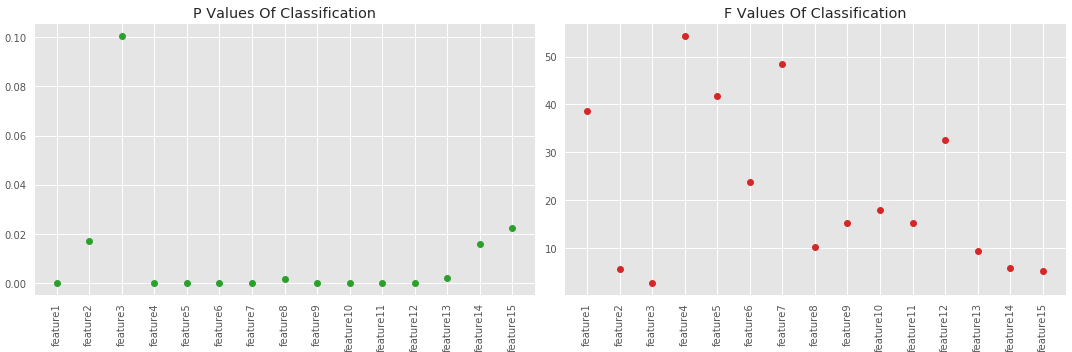

In [11]:
X = data_latest[['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10', 'feature11', 'feature12', 'feature13', 'feature14', 'feature15']]
Y = data_latest['label'].values

F_classif, p_value_classif = f_classif(X, Y)

with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(p_value_classif, 'o', c = 'tab:green')
    plt.xticks(range(X.shape[1]), ['feature' +str(i) for i in range(1, X.shape[1]+1)], rotation='vertical')
    plt.title('P Values Of Classification')
    plt.subplot(122)
    plt.plot(F_classif, 'o', c = 'tab:red')
    plt.xticks(range(X.shape[1]), ['feature' +str(i) for i in range(1, X.shape[1]+1)], rotation='vertical')
    plt.title('F Values Of Classification');
    plt.tight_layout()    

# Dividing Data Into Train/Test Sets
We have selected 15 features are our main features for prediction and label column as predicting column. We'll divide dataset into `90%` for training and `10%` for test.

In [12]:
X = data_latest[['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10', 'feature11', 'feature12', 'feature13', 'feature14', 'feature15']].values
Y = data_latest['label'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.9, test_size=0.1, shuffle=False)

print('Train/Test Sizes : ', X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
sm = SMOTE()
X_train, Y_train = sm.fit_sample(X_train, Y_train)

print('Train/Test Sizes : ', X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

Train/Test Sizes :  (2475, 15) (276, 15) (2475,) (276,)
Train/Test Sizes :  (4650, 15) (276, 15) (4650,) (276,)


In [13]:
Counter(Y_train), Counter(Y_test)

(Counter({0: 2325, 1: 2325}), Counter({0: 250, 1: 26}))

### Visualisation Generic Functions
Below we have designed 2 function which will help up print various results.

1. `plot_confusion_matrix` - Plots confusion matrix given actual values and predictions
2. `plot_loss_and_accuracy` - Plots train/val loss and train/val accuracy for classification task and train/val MSE for regression task.

In [14]:
def plot_confusion_matrix(actuals, preds):
    conf_mat = confusion_matrix(Y_test, predictions)
    with plt.style.context(('seaborn', 'ggplot')):
        fig = plt.figure(figsize=(5,5))
        plt.matshow(conf_mat, cmap=plt.cm.Blues, fignum=1)
        plt.grid(None)
        plt.xticks([0,1], [0, 1])
        plt.yticks([0,1], [0, 1])
        plt.ylabel('Actual')
        plt.xlabel('Prediction')
        plt.colorbar();
        for i in range(conf_mat.shape[0]):
            for j in range(conf_mat.shape[1]):
                plt.text(j, i, str(conf_mat[i, j]), horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
                
def plot_loss_and_accuracy(hist, prob_type='classification'):
    with plt.style.context(('seaborn', 'ggplot')):
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.plot(hist.history['loss'], label='Train Loss')
        plt.plot(hist.history['val_loss'], label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='best')
        
        if prob_type=='classification':
            plt.subplot(122)
            plt.plot(hist.history['accuracy'], label='Train Accuracy')
            plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend(loc='best')
        elif prob_type=='regression':
            plt.subplot(122)
            plt.plot(hist.history['mse'], label='Train MSE')
            plt.plot(hist.history['val_mse'], label='Val MSE')
            plt.xlabel('Epochs')
            plt.ylabel('MSE')
            plt.legend(loc='best')

# DenseNet v1
Below dense model consist of 4 dense layers with dimensions 128, 64,32,1 respectively. For internal layers we have selected activation function as relu. Last layer has activation function as sigmoid because its classification problem.

In [15]:
dense_model1 = Sequential([ Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
                     Dense(64,  activation='relu'),
                     Dense(32,  activation='relu'),
                     Dense(1,   activation='sigmoid')])

print(dense_model1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 12,417
Trainable params: 12,417
Non-trainable params: 0
_________________________________________________________________
None


## Compiling Model
Compiling Model involves setting optimizers to use, loss and evaluation metrics.

In [16]:
dense_model1.compile('adam', loss='binary_crossentropy', metrics = ['accuracy'])

## Fitting Model
Below we are fitting model with batch size of 4 for 25 epochs. We'll use 10% of train data as validation data for evaluation of performance during training.

In [17]:
history = dense_model1.fit(X_train, Y_train, batch_size=4, epochs=10, validation_split=0.1, use_multiprocessing=True);

Train on 4185 samples, validate on 465 samples
Epoch 1/10
4185/4185 [==============================] - 3s 597us/step - loss: 0.6846 - accuracy: 0.6041 - val_loss: 0.7190 - val_accuracy: 0.4624
Epoch 2/10
4185/4185 [==============================] - 2s 501us/step - loss: 0.6527 - accuracy: 0.6327 - val_loss: 0.8393 - val_accuracy: 0.3699
Epoch 3/10
4185/4185 [==============================] - 2s 500us/step - loss: 0.6397 - accuracy: 0.6397 - val_loss: 1.0498 - val_accuracy: 0.0688
Epoch 4/10
4185/4185 [==============================] - 2s 502us/step - loss: 0.6326 - accuracy: 0.6375 - val_loss: 0.7388 - val_accuracy: 0.4624
Epoch 5/10
4185/4185 [==============================] - 2s 500us/step - loss: 0.6155 - accuracy: 0.6566 - val_loss: 0.7410 - val_accuracy: 0.4731
Epoch 6/10
4185/4185 [==============================] - 2s 552us/step - loss: 0.5811 - accuracy: 0.6786 - val_loss: 0.5425 - val_accuracy: 0.7892
Epoch 7/10
4185/4185 [==============================] - 2s 510us/step - loss:

## Visualizing Training Stage Results

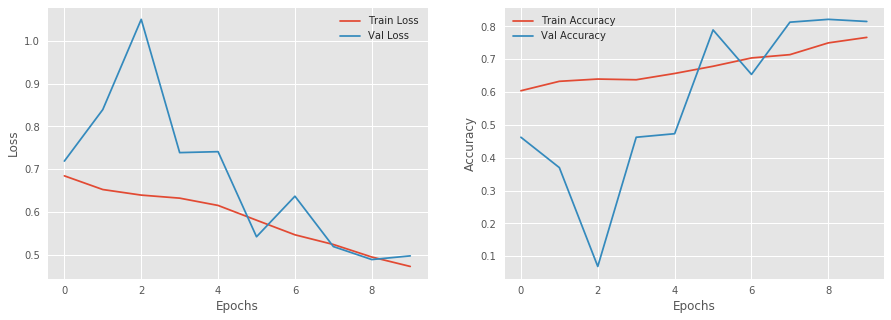

In [18]:
plot_loss_and_accuracy(history)

## Performance Evaluation on Test Data

In [19]:
predictions = dense_model1.predict_classes(X_test)
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

Accuracy : 0.591


In [20]:
predictions_full = dense_model1.predict_classes(X)
print('Accuracy : %.3f'%accuracy_score(Y, predictions_full))

Accuracy : 0.726


In [21]:
softmax_vals = dense_model1.predict_proba(X)
df1 = copy.deepcopy(data_latest)
df1['Preds'] = predictions_full
zero_prob, one_prob = [], []
for val in softmax_vals:
    if val[0] <= 0.5:
        zero_prob.append(1-val[0])
        one_prob.append(val[0])
    else:
        one_prob.append(val[0])
        zero_prob.append(1-val[0])

df1['0_prob'] = zero_prob
df1['1_prob'] = one_prob

## Printing/Plotting Classification Metrics

Classification Report : 
               precision    recall  f1-score   support

           0       0.94      0.59      0.72       250
           1       0.13      0.62      0.22        26

    accuracy                           0.59       276
   macro avg       0.54      0.60      0.47       276
weighted avg       0.86      0.59      0.68       276

Confusion Matrix : 
 [[147 103]
 [ 10  16]]


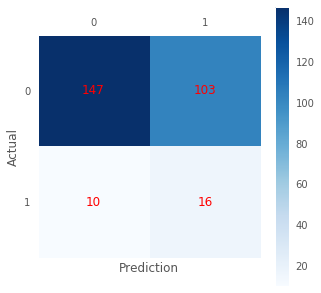

In [22]:
results = []
def print_plot_metrics(model_name, actual_rets_test, Y_test, predictions):
    print('Classification Report : \n',classification_report(Y_test, predictions))
    print('Confusion Matrix : \n', confusion_matrix(Y_test, predictions))
    plot_confusion_matrix(Y_test, predictions)

print_plot_metrics('DenseNetv1', None, Y_test, predictions)

## Visualising Weights
Below we are visualising average weights of first layer which has same shape as that of number of features.

Layer : Dense : Weights : (15, 128)
Layer : Dense : Bias : (128,)
Layer : Dense : Weights : (128, 64)
Layer : Dense : Bias : (64,)
Layer : Dense : Weights : (64, 32)
Layer : Dense : Bias : (32,)
Layer : Dense : Weights : (32, 1)
Layer : Dense : Bias : (1,)


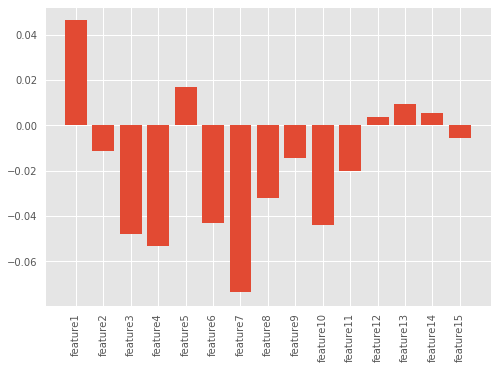

In [23]:
def print_weights_per_layer(model):
    weights = model.get_weights()
    layers = [layer for layer in model.layers if layer.__class__.__name__ != 'Dropout']

    i = 0
    for layer in layers:
        if layer.__class__.__name__ =='Dense':
            print('Layer : %s : Weights : %s'%(layer.__class__.__name__, weights[i].shape))
            print('Layer : %s : Bias : %s'%(layer.__class__.__name__, weights[i+1].shape))
            i = i+2
        else:
            print('Layer : %s : Weights : %s'%(layer.__class__.__name__, weights[i].shape))
            i = i+1

print_weights_per_layer(dense_model1)

dense_weights = dense_model1.get_weights()
important_weights = dense_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.bar(x=['feature'+str(i) for i in range(1,16)], height=important_weights, width=0.8)
    plt.xticks(rotation='vertical')

# DenseNet v2
Below we have deisigned another dense net model which has 6 layers of shapes 512,256,128,64,32 and 1 respectively. We have used relu as activation function for internal layers and sigmoid for last layer. We also have used Dropout of 20% this time between each layer to see whether it help improve performance.

In [24]:
dense_model2 = Sequential([ 
                     Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
                     Dropout(0.5),
                     Dense(256,  activation='relu'),
                     Dropout(0.5),
                     Dense(128,  activation='relu'),
                     Dropout(0.5),
                     Dense(64,  activation='relu'),
                     Dropout(0.5),
                     Dense(32,  activation='relu'),
                     Dropout(0.5),
                     Dense(1,   activation='sigmoid')])

print(dense_model2.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

## Compiling Model

In [25]:
dense_model2.compile('adam', loss='binary_crossentropy', metrics = ['accuracy'])

## Fitting Model

In [26]:
history = dense_model2.fit(X_train, Y_train, batch_size=4, epochs=10, validation_split=0.1, use_multiprocessing=True);

Train on 4185 samples, validate on 465 samples
Epoch 1/10
4185/4185 [==============================] - 6s 1ms/step - loss: 1.1949 - accuracy: 0.5159 - val_loss: 0.7357 - val_accuracy: 0.0000e+00
Epoch 2/10
4185/4185 [==============================] - 5s 1ms/step - loss: 0.7180 - accuracy: 0.5269 - val_loss: 0.7402 - val_accuracy: 0.0000e+00
Epoch 3/10
4185/4185 [==============================] - 5s 1ms/step - loss: 0.6994 - accuracy: 0.5458 - val_loss: 0.7632 - val_accuracy: 0.0000e+00
Epoch 4/10
4185/4185 [==============================] - 5s 1ms/step - loss: 0.6909 - accuracy: 0.5553 - val_loss: 0.7642 - val_accuracy: 0.0000e+00
Epoch 5/10
4185/4185 [==============================] - 5s 1ms/step - loss: 0.6903 - accuracy: 0.5584 - val_loss: 0.7679 - val_accuracy: 0.0000e+00
Epoch 6/10
4185/4185 [==============================] - 5s 1ms/step - loss: 0.6854 - accuracy: 0.5603 - val_loss: 0.7377 - val_accuracy: 0.0022
Epoch 7/10
4185/4185 [==============================] - 5s 1ms/step -

## Visualising Training Stage Results

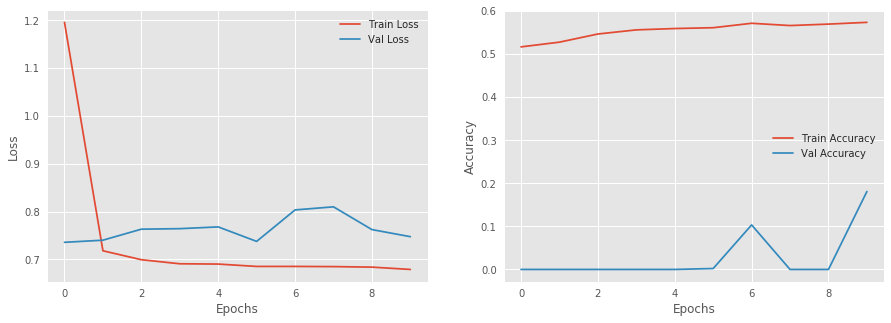

In [27]:
plot_loss_and_accuracy(history)

## Performance Evaluation on Test Data

In [28]:
predictions = dense_model2.predict_classes(X_test)
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

Accuracy : 0.793


In [29]:
predictions_full = dense_model2.predict_classes(X)
print('Accuracy : %.3f'%accuracy_score(Y, predictions_full))

Accuracy : 0.895


In [30]:
softmax_vals = dense_model2.predict_proba(X)
df2 = copy.deepcopy(data_latest)
df2['Preds'] = predictions_full
zero_prob, one_prob = [], []
for val in softmax_vals:
    if val[0] <= 0.5:
        zero_prob.append(1-val[0])
        one_prob.append(val[0])
    else:
        one_prob.append(val[0])
        zero_prob.append(1-val[0])

df2['0_prob'] = zero_prob
df2['1_prob'] = one_prob

## Printing/Plotting Classification Metrics

Classification Report : 
               precision    recall  f1-score   support

           0       0.92      0.85      0.88       250
           1       0.16      0.27      0.20        26

    accuracy                           0.79       276
   macro avg       0.54      0.56      0.54       276
weighted avg       0.85      0.79      0.82       276

Confusion Matrix : 
 [[212  38]
 [ 19   7]]


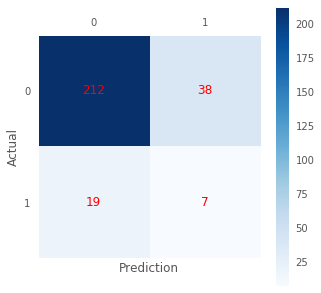

In [31]:
print_plot_metrics('DenseNetv2', None, Y_test, predictions)

Layer : Dense : Weights : (15, 512)
Layer : Dense : Bias : (512,)
Layer : Dense : Weights : (512, 256)
Layer : Dense : Bias : (256,)
Layer : Dense : Weights : (256, 128)
Layer : Dense : Bias : (128,)
Layer : Dense : Weights : (128, 64)
Layer : Dense : Bias : (64,)
Layer : Dense : Weights : (64, 32)
Layer : Dense : Bias : (32,)
Layer : Dense : Weights : (32, 1)
Layer : Dense : Bias : (1,)


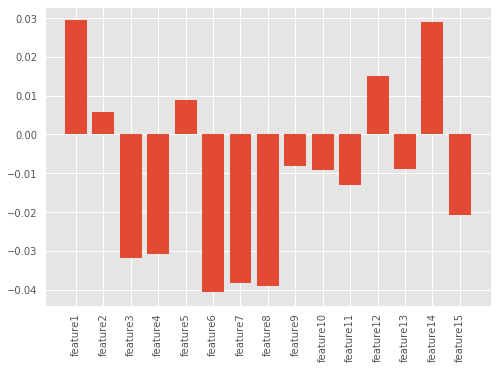

In [32]:
print_weights_per_layer(dense_model2)

dense_weights = dense_model2.get_weights()
important_weights = dense_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.bar(x=['feature'+str(i) for i in range(1,16)], height=important_weights, width=0.8)
    plt.xticks(rotation='vertical')

# XGB Booster
### Fitting Model

In [33]:
dtotal = xgb.DMatrix(data=X, label=Y)
dtrain = xgb.DMatrix(data=X_train, label=Y_train)
dtest = xgb.DMatrix(data=X_test, label=Y_test)

params = {
    'n_estimators':250,
    'verbosity':1,
    'max_depth': 8,
    'eta': 0.3,
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': len(set(Y)),
}
num_round = 20 
bst = xgb.train(params, dtrain, num_round)

### Performance Evaluation on Test Data

In [34]:
predictions = bst.predict(dtest)
predictions = np.asarray([np.argmax(line) for line in predictions])
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

Accuracy : 0.873


In [35]:
predictions_full = bst.predict(dtotal)
predictions_full = np.asarray([np.argmax(line) for line in predictions_full])
print('Accuracy : %.3f'%accuracy_score(Y, predictions_full))

Accuracy : 0.975


In [36]:
probs = bst.predict(dtotal)
#print(softmax_vals[:,i].shape)
df3 = copy.deepcopy(data_latest)
df3['Preds'] = predictions_full
for col in ['0','1']:
    df3[col + '_probs'] = probs[:,int(col)]

### Printing/Plotting Classification Metrics

Classification Report : 
               precision    recall  f1-score   support

           0       0.92      0.95      0.93       250
           1       0.24      0.15      0.19        26

    accuracy                           0.87       276
   macro avg       0.58      0.55      0.56       276
weighted avg       0.85      0.87      0.86       276

Confusion Matrix : 
 [[237  13]
 [ 22   4]]


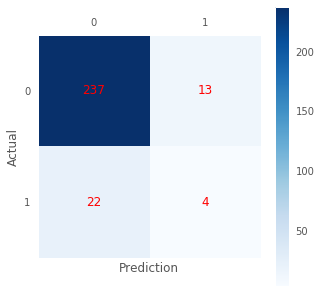

In [37]:
def print_plot_metrics(model_name, actual_rets_test, Y_test, predictions):
    print('Classification Report : \n',classification_report(Y_test, predictions))
    print('Confusion Matrix : \n', confusion_matrix(Y_test, predictions))
    plot_confusion_matrix(Y_test, predictions)

print_plot_metrics('XGBClassifier', None, Y_test, predictions)

# XGB Classifier

In [38]:
xgb_classif = xgb.XGBRFClassifier(n_estimators=250, max_depth=8, objective='binary:logistic', verbosity=1)

### Fitting Model

In [39]:
xgb_classif.fit(X_train, Y_train)

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
                max_depth=8, min_child_weight=1, missing=None, n_estimators=250,
                n_jobs=1, nthread=None, objective='binary:logistic',
                random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                seed=None, silent=None, subsample=0.8, verbosity=1)

### Performance Evaluation on Test Data

In [40]:
predictions = xgb_classif.predict(X_test)
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

Accuracy : 0.790


In [41]:
predictions_full = xgb_classif.predict(X)
print('Accuracy : %.3f'%accuracy_score(Y, predictions_full))

Accuracy : 0.858


In [42]:
probs = xgb_classif.predict_proba(X)
#print(softmax_vals[:,i].shape)
df4 = copy.deepcopy(data_latest)
df4['Preds'] = predictions_full
for col in ['0','1']:
    df4[col + '_probs'] = probs[:,int(col)]

### Printing/Plotting Classification Metrics

Classification Report : 
               precision    recall  f1-score   support

           0       0.92      0.84      0.88       250
           1       0.15      0.27      0.19        26

    accuracy                           0.79       276
   macro avg       0.53      0.56      0.54       276
weighted avg       0.85      0.79      0.81       276

Confusion Matrix : 
 [[211  39]
 [ 19   7]]


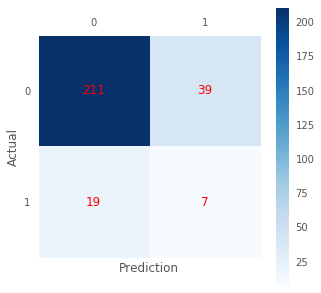

In [43]:
print_plot_metrics('XGB', None, Y_test, predictions)

# XGB RF Classifier

In [44]:
xgb_rfclassif = xgb.XGBRFClassifier(n_estimators=300, max_depth=8, objective='binary:logistic', verbosity=1)

### Fitting Model

In [45]:
xgb_rfclassif.fit(X_train, Y_train)

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
                max_depth=8, min_child_weight=1, missing=None, n_estimators=300,
                n_jobs=1, nthread=None, objective='binary:logistic',
                random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                seed=None, silent=None, subsample=0.8, verbosity=1)

### Performance Evaluation on Test Data

In [46]:
predictions = xgb_rfclassif.predict(X_test)
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

Accuracy : 0.804


In [47]:
predictions_full = xgb_rfclassif.predict(X)
print('Accuracy : %.3f'%accuracy_score(Y, predictions_full))

Accuracy : 0.858


In [48]:
probs = xgb_rfclassif.predict_proba(X)
#print(softmax_vals[:,i].shape)
df5 = copy.deepcopy(data_latest)
df5['Preds'] = predictions_full
for col in ['0','1']:
    df5[col + '_probs'] = probs[:,int(col)]

### Printing/Plotting Classification Metrics

Classification Report : 
               precision    recall  f1-score   support

           0       0.92      0.86      0.89       250
           1       0.17      0.27      0.21        26

    accuracy                           0.80       276
   macro avg       0.54      0.56      0.55       276
weighted avg       0.85      0.80      0.82       276

Confusion Matrix : 
 [[215  35]
 [ 19   7]]


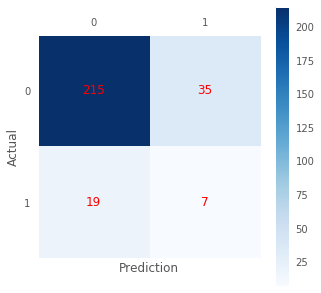

In [49]:
print_plot_metrics('XGBRFClassifier', None, Y_test, predictions)

# Time Series Approach With LSTM (Classification) v1

Below we are preparing data for LSTM. We are taking look back size of 50 so that we'll look at 50 previous sample to predict current one. We are organizing our dataset in that format so that it can be fed into LSTM.

In [50]:
def prepare_dataset(features,labels, look_back=1):
    X, Y = [], []
    for i in range(len(features)-look_back):
        a = features[i:(i+look_back), :]
        X.append(a)
        Y.append(labels[i + look_back])
    return np.array(X), np.array(Y)

X = data_latest[['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10', 'feature11', 'feature12', 'feature13', 'feature14', 'feature15']].values
Y = data_latest['label'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.9, test_size=0.1, shuffle=False)

print('Actual Data Size : ', X.shape, Y.shape)
print('Train/Test Sizes : ', X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

# split into input and outputs
look_back = 50
X_train, Y_train = prepare_dataset(X_train, Y_train, look_back)
X_test, Y_test = prepare_dataset(X_test, Y_test, look_back)

X_new, Y_new = prepare_dataset(X, Y, look_back)
print('Modified Data Size : ', X_new.shape, Y_new.shape)
print('Train/Test Sizes Modified', X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

Actual Data Size :  (2751, 15) (2751,)
Train/Test Sizes :  (2475, 15) (276, 15) (2475,) (276,)
Modified Data Size :  (2701, 50, 15) (2701,)
Train/Test Sizes Modified (2425, 50, 15) (2425,) (226, 50, 15) (226,)


Below we have defined LSTM network of only 50 units. This parameter can be tweaked to check whether it improves performance further in future. My guess is that if we increase its value further then it'll performance. Output layer is again sigmoid.

In [51]:
lstm_classif = Sequential([
                        LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
                        Dropout(0.2),
                        Dense(1, activation='sigmoid')                        
                        ])

print(lstm_classif.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                13200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
Total params: 13,251
Trainable params: 13,251
Non-trainable params: 0
_________________________________________________________________
None


## Compiling Model

In [52]:
lstm_classif.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Fitting Model

In [53]:
history = lstm_classif.fit(X_train, Y_train, epochs=8, batch_size=8, validation_data=(X_test, Y_test), verbose=1, shuffle=False)

Train on 2425 samples, validate on 226 samples
Epoch 1/8
2425/2425 [==============================] - 10s 4ms/step - loss: 0.2932 - accuracy: 0.9006 - val_loss: 0.3088 - val_accuracy: 0.9027
Epoch 2/8
2425/2425 [==============================] - 9s 4ms/step - loss: 0.2329 - accuracy: 0.9402 - val_loss: 0.3100 - val_accuracy: 0.9027
Epoch 3/8
2425/2425 [==============================] - 9s 4ms/step - loss: 0.2214 - accuracy: 0.9402 - val_loss: 0.3079 - val_accuracy: 0.9027
Epoch 4/8
2425/2425 [==============================] - 9s 4ms/step - loss: 0.2241 - accuracy: 0.9402 - val_loss: 0.3064 - val_accuracy: 0.9027
Epoch 5/8
2425/2425 [==============================] - 9s 4ms/step - loss: 0.2272 - accuracy: 0.9402 - val_loss: 0.3090 - val_accuracy: 0.9027
Epoch 6/8
2425/2425 [==============================] - 9s 4ms/step - loss: 0.2216 - accuracy: 0.9402 - val_loss: 0.3095 - val_accuracy: 0.9027
Epoch 7/8
2425/2425 [==============================] - 9s 4ms/step - loss: 0.2222 - accuracy: 

## Visualizing Training Stage Results

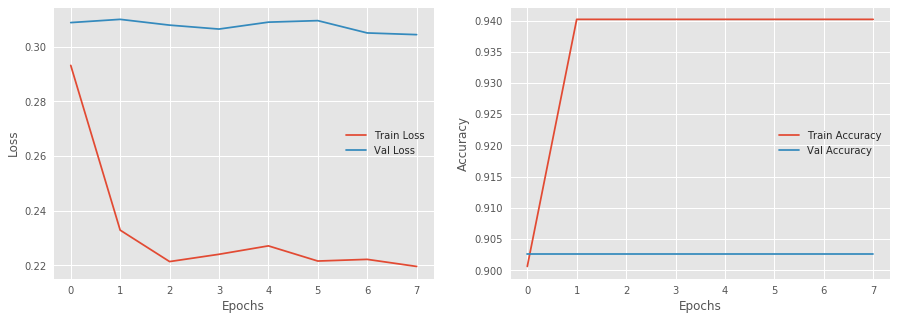

In [54]:
plot_loss_and_accuracy(history)

## Performance Evaluation on Test Data

In [55]:
predictions = lstm_classif.predict_classes(X_test)
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

Accuracy : 0.903


In [56]:
predictions_full = lstm_classif.predict_classes(X_new)
print('Accuracy : %.3f'%accuracy_score(Y_new, predictions_full))

Accuracy : 0.937


In [57]:
softmax_vals = lstm_classif.predict_proba(X_new)
df6 = copy.deepcopy(data_latest)
df6['Preds'] = np.hstack(([0]*look_back, predictions_full.flatten()))
zero_prob, one_prob = [], []
for val in softmax_vals:
    if val[0] <= 0.5:
        zero_prob.append(1-val[0])
        one_prob.append(val[0])
    else:
        one_prob.append(val[0])
        zero_prob.append(1-val[0])

df6['0_prob'] = np.hstack(([0]*look_back, zero_prob))
df6['1_prob'] = np.hstack(([0]*look_back, one_prob))

## Printing/Plotting Classification Metrics

Classification Report : 
               precision    recall  f1-score   support

           0       0.90      1.00      0.95       204
           1       0.00      0.00      0.00        22

    accuracy                           0.90       226
   macro avg       0.45      0.50      0.47       226
weighted avg       0.81      0.90      0.86       226

Confusion Matrix : 
 [[204   0]
 [ 22   0]]


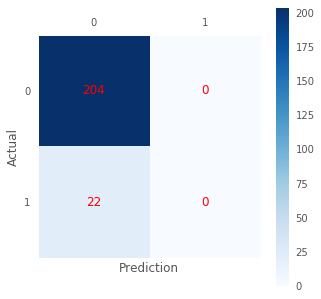

In [58]:
print_plot_metrics('LSTMv1', None, Y_test, predictions)

## Visualising Weights

Layer : LSTM : Weights : (15, 200)
Layer : Dense : Weights : (50, 200)
Layer : Dense : Bias : (200,)


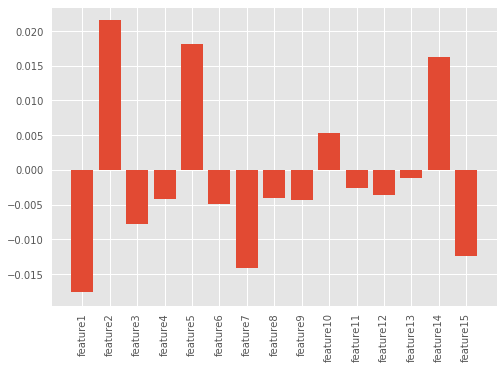

In [59]:
print_weights_per_layer(lstm_classif)

lstm_weights = lstm_classif.get_weights()
important_weights = lstm_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.bar(x=['feature'+str(i) for i in range(1,16)], height=important_weights, width=0.8)
    plt.xticks(rotation='vertical')

# Time Series Approach With LSTM (Classification) v2
Below we have defined another LSTM model which has 3 LSTM layers of all same unit sizes of 30. Last layer is again sigmoid layer.

In [60]:
lstm_classif = Sequential([
                LSTM(units=30, return_sequences= True, input_shape=(X_train.shape[1],X_train.shape[2])),
                LSTM(units=30, return_sequences=True),
                LSTM(units=30),
                Dense(1, activation='sigmoid')
                ])

print(lstm_classif.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 30)            5520      
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_4 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 31        
Total params: 20,191
Trainable params: 20,191
Non-trainable params: 0
_________________________________________________________________
None


## Compiling Model

In [61]:
lstm_classif.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Fitting Model

In [62]:
history = lstm_classif.fit(X_train, Y_train, epochs=8, batch_size=8, validation_data=(X_test, Y_test), verbose=1, shuffle=False)

Train on 2425 samples, validate on 226 samples
Epoch 1/8
2425/2425 [==============================] - 26s 11ms/step - loss: 0.2446 - accuracy: 0.9402 - val_loss: 0.3209 - val_accuracy: 0.9027
Epoch 2/8
2425/2425 [==============================] - 25s 10ms/step - loss: 0.2277 - accuracy: 0.9402 - val_loss: 0.3174 - val_accuracy: 0.9027
Epoch 3/8
2425/2425 [==============================] - 24s 10ms/step - loss: 0.2263 - accuracy: 0.9402 - val_loss: 0.3142 - val_accuracy: 0.9027
Epoch 4/8
2425/2425 [==============================] - 25s 10ms/step - loss: 0.2253 - accuracy: 0.9402 - val_loss: 0.3135 - val_accuracy: 0.9027
Epoch 5/8
2425/2425 [==============================] - 26s 11ms/step - loss: 0.2240 - accuracy: 0.9402 - val_loss: 0.3128 - val_accuracy: 0.9027
Epoch 6/8
2425/2425 [==============================] - 24s 10ms/step - loss: 0.2236 - accuracy: 0.9402 - val_loss: 0.3131 - val_accuracy: 0.9027
Epoch 7/8
2425/2425 [==============================] - 24s 10ms/step - loss: 0.2224

## Visualizing Training Stage Results

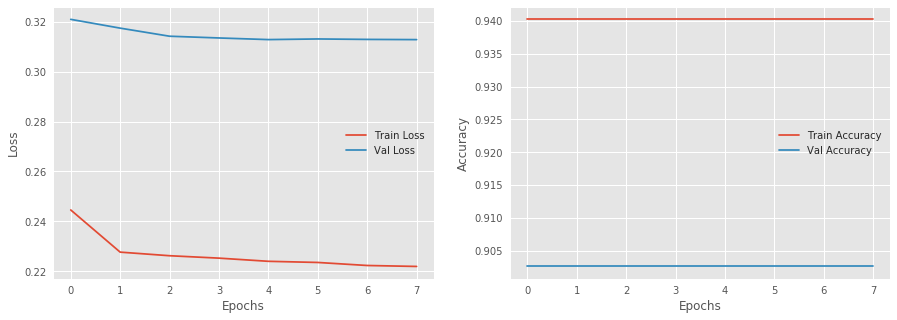

In [63]:
plot_loss_and_accuracy(history)

## Performance Evaluation on Test Data

In [64]:
predictions = lstm_classif.predict_classes(X_test)
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

Accuracy : 0.903


In [65]:
predictions_full = lstm_classif.predict_classes(X_new)
print('Accuracy : %.3f'%accuracy_score(Y_new, predictions_full))

Accuracy : 0.937


In [66]:
softmax_vals = lstm_classif.predict_proba(X_new)
df7 = copy.deepcopy(data_latest)
df7['Preds'] = np.hstack(([0]*look_back, predictions_full.flatten()))
zero_prob, one_prob = [], []
for val in softmax_vals:
    if val[0] <= 0.5:
        zero_prob.append(1-val[0])
        one_prob.append(val[0])
    else:
        one_prob.append(val[0])
        zero_prob.append(1-val[0])

df7['0_prob'] = np.hstack(([0]*look_back, zero_prob))
df7['1_prob'] = np.hstack(([0]*look_back, one_prob))

## Printing/Plotting Classification Metrics

Classification Report : 
               precision    recall  f1-score   support

           0       0.90      1.00      0.95       204
           1       0.00      0.00      0.00        22

    accuracy                           0.90       226
   macro avg       0.45      0.50      0.47       226
weighted avg       0.81      0.90      0.86       226

Confusion Matrix : 
 [[204   0]
 [ 22   0]]


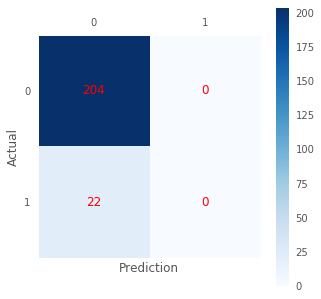

In [67]:
print_plot_metrics('LSTMv2' , None, Y_test, predictions)

## Visualising Weights

Layer : LSTM : Weights : (15, 120)
Layer : LSTM : Weights : (30, 120)
Layer : LSTM : Weights : (120,)
Layer : Dense : Weights : (30, 120)
Layer : Dense : Bias : (30, 120)


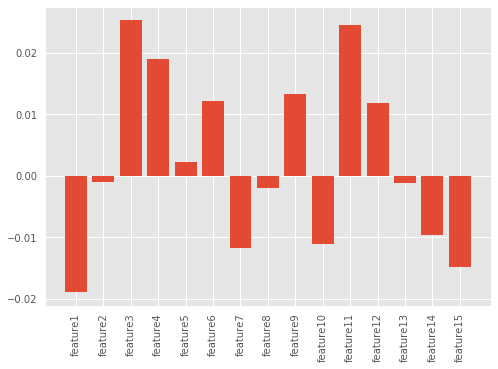

In [68]:
print_weights_per_layer(lstm_classif)

lstm_weights = lstm_classif.get_weights()
important_weights = lstm_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.bar(x=['feature'+str(i) for i in range(1,16)], height=important_weights, width=0.8)
    plt.xticks(rotation='vertical')

In [69]:
with pd.ExcelWriter('Final_Output.xlsx') as writer:
    for sheet_name, df in [('DenseNetv1',df1), ('DenseNetv2',df2), ('XGBooster', df3), ('XGBClassif', df4), ('XGBRFClassif', df5), ('LSTMv1', df6), ('LSTMv2', df7)]:
        df.to_excel(writer, sheet_name= sheet_name)

In [70]:
from IPython.display import FileLink
FileLink('Final_Output.xlsx')

/kaggle/working/Final_Output.xlsx